# The Settlers of Catan Scoring

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thesettlersofcatan/catan_scores.csv


In [3]:
raw_scores = pd.read_csv(os.path.join(dirname, filename))
raw_scores.head(10)

,game_id,date,player,rank,substitute_player,winner,score,color,num_of_cities,num_of_settlement,...,first_lumber_harbor,first_3to1_harbor,num_of_brick_harbor,num_of_grain_harbor,num_of_3to1_harbor,num_of_lumber_harbor,num_of_ore_harbor,num_of_wool_harbor,initial_dices,dessert_placement
0,1.0,2022-02-22,B,1.0,NaN,A,7.0,Blue,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2022-02-22,A,2.0,NaN,A,10.0,White,5.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2022-02-22,V,4.0,Cc,A,8.0,Red,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,2022-02-22,M,3.0,E,A,7.0,Orange,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,2022-03-06,A,2.0,NaN,Cc,5.0,White,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2.0,2022-03-06,F,1.0,NaN,Cc,6.0,Orange,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.0,2022-03-06,Cc,3.0,NaN,Cc,10.0,Red,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.0,2022-03-08,B,4.0,F,M,6.0,Red,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3.0,2022-03-08,A,3.0,NaN,M,7.0,White,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.0,2022-03-08,Cc,1.0,NaN,M,8.0,Blue,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# There was a mistake in our edition, there were 5 cities for the color orange.
# So at the beginning, some players played with 5 cities and win easily.
# We can eliminate these games.
remove_5_city_games = False
include_substitute_players = True


In [5]:
if remove_5_city_games:
    raw_scores["problematic_games"] = 0
    raw_scores.loc[raw_scores["game_id"].isin(list(raw_scores[raw_scores["num_of_cities"] == 5]["game_id"].unique())), \
               "problematic_games"] = 1
    raw_scores = raw_scores[~raw_scores["game_id"].isin(raw_scores[raw_scores["num_of_cities"] == 5]["Ogame_id"].unique())]

In [6]:
raw_scores.columns

Index(['game_id', 'date', 'player', 'rank', 'substitute_player', 'winner',
       'score', 'color', 'num_of_cities', 'num_of_settlement', 'num_of_roads',
       'num_of_dev_cards', 'buy_dev_card_first', 'builds_city_first',
       'builds_settlement_first', 'num_of_harbor', 'which_resources_first',
       'cashier', 'time_in_min', 'is_extension', 'start_time', 'longest_road',
       'largest_army', 'first_brick_harbor', 'first_ore_harbor',
       'first_grain_harbor', 'first_wool_harbor', 'first_lumber_harbor',
       'first_3to1_harbor', 'num_of_brick_harbor', 'num_of_grain_harbor',
       'num_of_3to1_harbor', 'num_of_lumber_harbor', 'num_of_ore_harbor',
       'num_of_wool_harbor', 'initial_dices', 'dessert_placement'],
      dtype='object')

In [7]:
# Find number of players per game & avg. time per player
raw_scores["player_count"] = raw_scores.groupby("game_id")["rank"].transform('max')
raw_scores["avg_time_per_player"] = raw_scores["time_in_min"] / raw_scores["player_count"]

In [8]:
def check_player_time(df: pd.DataFrame, player_name: str, time_col: str):
    time_dict = {"avg_time_per_player": "Time Per Player",
                "time_in_min": "Game Time"}
    time_str = time_dict[time_col]
    player_games = df.loc[(df["player"] == player_name) | (df["substitute_player"] == player_name)]["game_id"].unique()
    avg_player_time = (df.loc[df["game_id"].isin(player_games)].groupby("game_id")[time_col].max().sum())\
      /(df.loc[df["game_id"].isin(player_games)]["game_id"].nunique())
    avg_wo_player_time = (df.loc[~df["game_id"].isin(player_games)].groupby("game_id")[time_col].max().sum()) \
      /(df.loc[~df["game_id"].isin(player_games)]["game_id"].nunique())
    total_player_games = df.loc[~df["game_id"].isin(player_games)]["game_id"].nunique()
    
    msg = f"""
    Player {player_name} played in {len(player_games)} out of {total_player_games} games ({round(100*len(player_games)/total_player_games, 2)}%).\n
    Avg. {time_str} (min): {round(avg_player_time, 3)}.\n
    Avg. {time_str} without him/her (min): {round(avg_wo_player_time, 3)}
    """
    print(msg)

In [9]:
check_player_time(df=raw_scores, player_name="V", time_col="time_in_min")
check_player_time(df=raw_scores, player_name="V", time_col="avg_time_per_player")


    Player V played in 24 out of 51 games (47.06%).

    Avg. Game Time (min): 80.292.

    Avg. Game Time without him/her (min): 59.608
    

    Player V played in 24 out of 51 games (47.06%).

    Avg. Time Per Player (min): 17.361.

    Avg. Time Per Player without him/her (min): 15.521
    


In [10]:
time_col = "time_in_min"

extension = raw_scores.loc[raw_scores["is_extension"] == 1]["game_id"].unique()
avg_extension_time= (raw_scores.loc[raw_scores["game_id"].isin(extension)].groupby("game_id")[time_col].max().sum()) \
      /(raw_scores.loc[raw_scores["game_id"].isin(extension)]["game_id"].nunique())
avg_regular_time = (raw_scores.loc[~raw_scores["game_id"].isin(extension)].groupby("game_id")[time_col].max().sum()) \
      /(raw_scores.loc[~raw_scores["game_id"].isin(extension)]["game_id"].nunique())

time_col = "avg_time_per_player"
extension = raw_scores.loc[raw_scores["is_extension"] == 1]["game_id"].unique()
avg_extension_time_per_player = (raw_scores.loc[raw_scores["game_id"].isin(extension)].groupby("game_id")[time_col].max().sum()) \
      /(raw_scores.loc[raw_scores["game_id"].isin(extension)]["game_id"].nunique())
avg_regular_time_per_player = (raw_scores.loc[~raw_scores["game_id"].isin(extension)].groupby("game_id")[time_col].max().sum()) \
      /(raw_scores.loc[~raw_scores["game_id"].isin(extension)]["game_id"].nunique())



print(f"""
Avg Extension Time (min): {round(avg_extension_time, 3)}
Avg Regular Time (min): {round(avg_regular_time, 3)}
Avg Extension Time per Player: {round(avg_extension_time_per_player, 3)}
Avg Regular Time per Player (min): {round(avg_regular_time_per_player, 3)}""")


Avg Extension Time (min): 76.0
Avg Regular Time (min): 61.041
Avg Extension Time per Player: 13.75
Avg Regular Time per Player (min): 17.362


### Player Count vs Time passed during Game

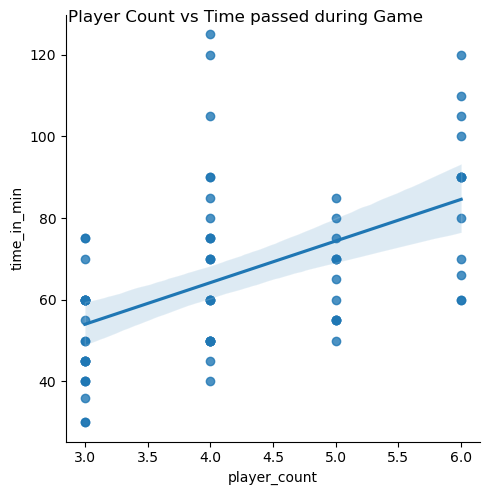

In [11]:
times = pd.merge(raw_scores.groupby("game_id", as_index=False).agg({"time_in_min": 'max'}),
         raw_scores.groupby("game_id", as_index=False).agg({"player_count": 'max'}), on="game_id")

sns.lmplot(x='player_count', y='time_in_min', data=times).fig.suptitle("Player Count vs Time passed during Game", fontsize=12)
sns.set_style('whitegrid')

In [12]:
raw_scores.columns

Index(['game_id', 'date', 'player', 'rank', 'substitute_player', 'winner',
       'score', 'color', 'num_of_cities', 'num_of_settlement', 'num_of_roads',
       'num_of_dev_cards', 'buy_dev_card_first', 'builds_city_first',
       'builds_settlement_first', 'num_of_harbor', 'which_resources_first',
       'cashier', 'time_in_min', 'is_extension', 'start_time', 'longest_road',
       'largest_army', 'first_brick_harbor', 'first_ore_harbor',
       'first_grain_harbor', 'first_wool_harbor', 'first_lumber_harbor',
       'first_3to1_harbor', 'num_of_brick_harbor', 'num_of_grain_harbor',
       'num_of_3to1_harbor', 'num_of_lumber_harbor', 'num_of_ore_harbor',
       'num_of_wool_harbor', 'initial_dices', 'dessert_placement',
       'player_count', 'avg_time_per_player'],
      dtype='object')

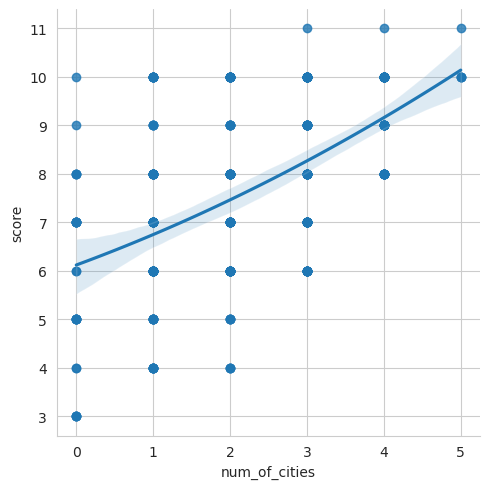

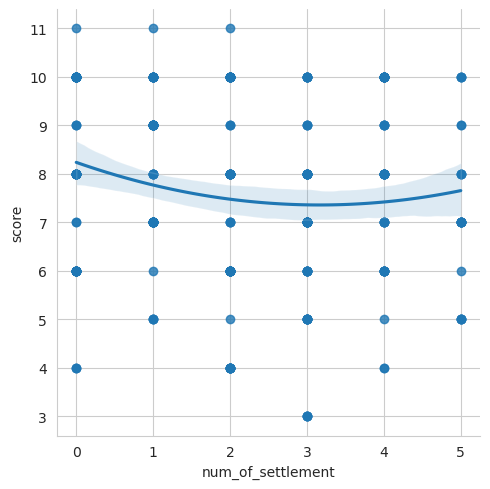

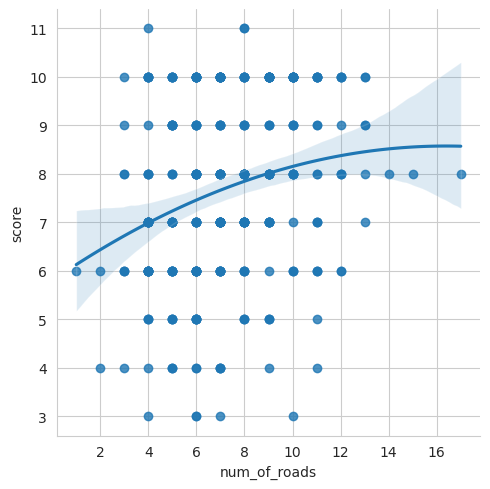

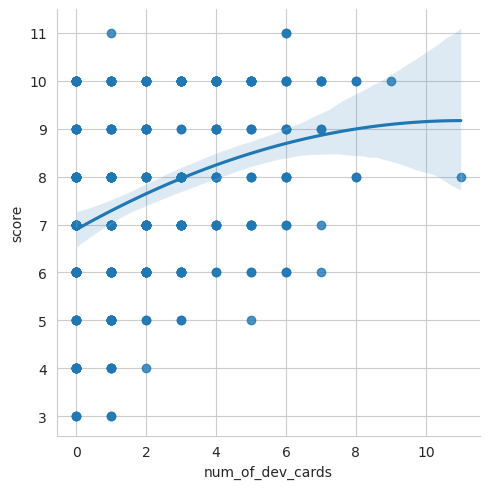

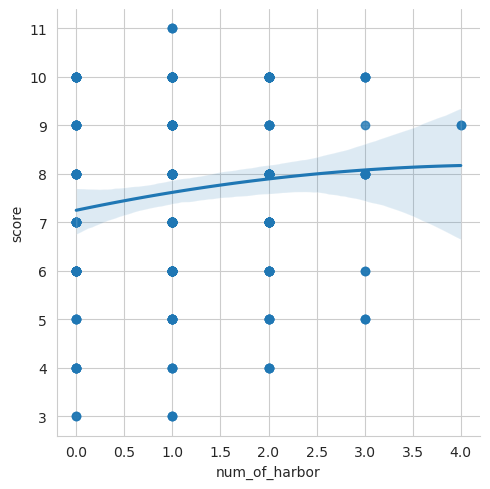

In [13]:
sns.lmplot(x='num_of_cities', y='score', data=raw_scores, order=2)
sns.lmplot(x='num_of_settlement', y='score', data=raw_scores, order=2)
sns.lmplot(x='num_of_roads', y='score', data=raw_scores, order=2)
sns.lmplot(x='num_of_dev_cards', y='score', data=raw_scores, order=2)
sns.lmplot(x='num_of_harbor', y='score', data=raw_scores, order=2)
sns.set_style('whitegrid')

### Time passed per player during game as the # of game increases

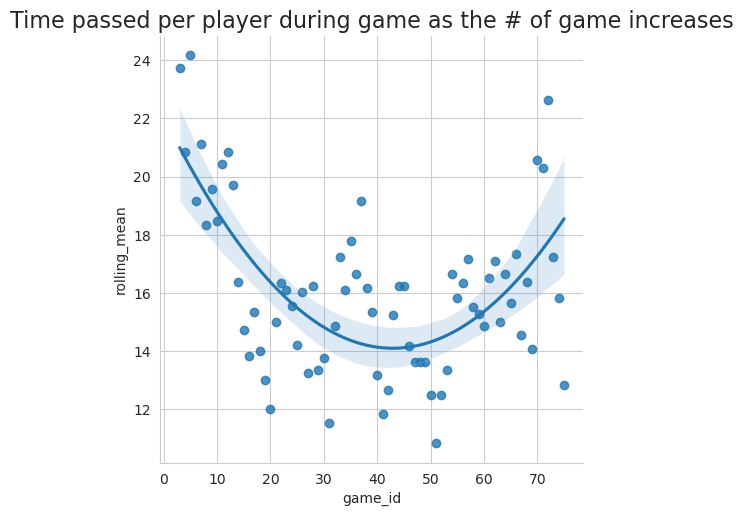

In [14]:
times["time_per_player"] = times["time_in_min"]/times["player_count"]
times["rolling_mean"] = times["time_per_player"].rolling(3).mean()
sns.lmplot(x="game_id", y="rolling_mean", data=times, order=2)

ax = plt.gca()
ax.set_title("Time passed per player during game as the # of game increases", fontsize=16)
sns.set_style('whitegrid')

In [15]:
total_time = raw_scores.groupby("game_id")["time_in_min"].max().sum()/60
avg_time = total_time/raw_scores["game_id"].max()
extension_percent = raw_scores.groupby("game_id")["is_extension"].max().sum()/raw_scores["game_id"].max()
shortest = raw_scores["time_in_min"].min()
longest = raw_scores["time_in_min"].max()
player_count_time = raw_scores[["player_count", "game_id", "time_in_min"]].drop_duplicates().groupby("player_count")["time_in_min"].mean()
print(f"""
Total Hours Played: {round(total_time, 2)}
Avg hour per game: {round(avg_time, 4)}
Extension Games: {round(100*extension_percent, 2)}%
Shortest Game (min): {round(shortest, 3)}
Longest Game (min): {round(longest, 3)}
""")


Total Hours Played: 82.78
Avg hour per game: 1.1038
Extension Games: 34.67%
Shortest Game (min): 30.0
Longest Game (min): 125.0



In [16]:
subs = raw_scores.loc[~raw_scores["substitute_player"].isnull()]

In [17]:
subs["player"] = subs["substitute_player"]
subs.head()

,game_id,date,player,rank,substitute_player,winner,score,color,num_of_cities,num_of_settlement,...,num_of_brick_harbor,num_of_grain_harbor,num_of_3to1_harbor,num_of_lumber_harbor,num_of_ore_harbor,num_of_wool_harbor,initial_dices,dessert_placement,player_count,avg_time_per_player
2,1.0,2022-02-22,Cc,4.0,Cc,A,8.0,Red,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,26.250000
3,1.0,2022-02-22,E,3.0,E,A,7.0,Orange,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,26.250000
7,3.0,2022-03-08,F,4.0,F,M,6.0,Red,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,30.000000
14,4.0,2022-03-09,F,4.0,F,B,4.0,White,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,17.500000
88,24.0,2022-04-01,F,2.0,F,E,8.0,White,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,6.0,18.333333


In [18]:
raw_scores = raw_scores[["game_id", "rank", "date", "player", "winner", "score",
                         "builds_city_first", "builds_settlement_first", "buy_dev_card_first",
                        "longest_road", "largest_army"]]
if include_substitute_players:
    subs = subs[["game_id", "rank", "date", "player", "winner", "score",
                         "builds_city_first", "builds_settlement_first", "buy_dev_card_first",
                        "longest_road", "largest_army"]]

    raw_scores = pd.concat([raw_scores, subs], axis=0)

In [19]:
def win_or_lose(player: str, winner: str):
    if player == winner:
        return 'W'
    else:
        return 'L'

In [20]:
raw_scores["result"] = "L"
raw_scores.loc[raw_scores["player"] == raw_scores["winner"], "result"] = "W"
scores = copy.deepcopy(raw_scores)

## Avg Points Per Player Per Game Type

<Figure size 2000x1200 with 0 Axes>

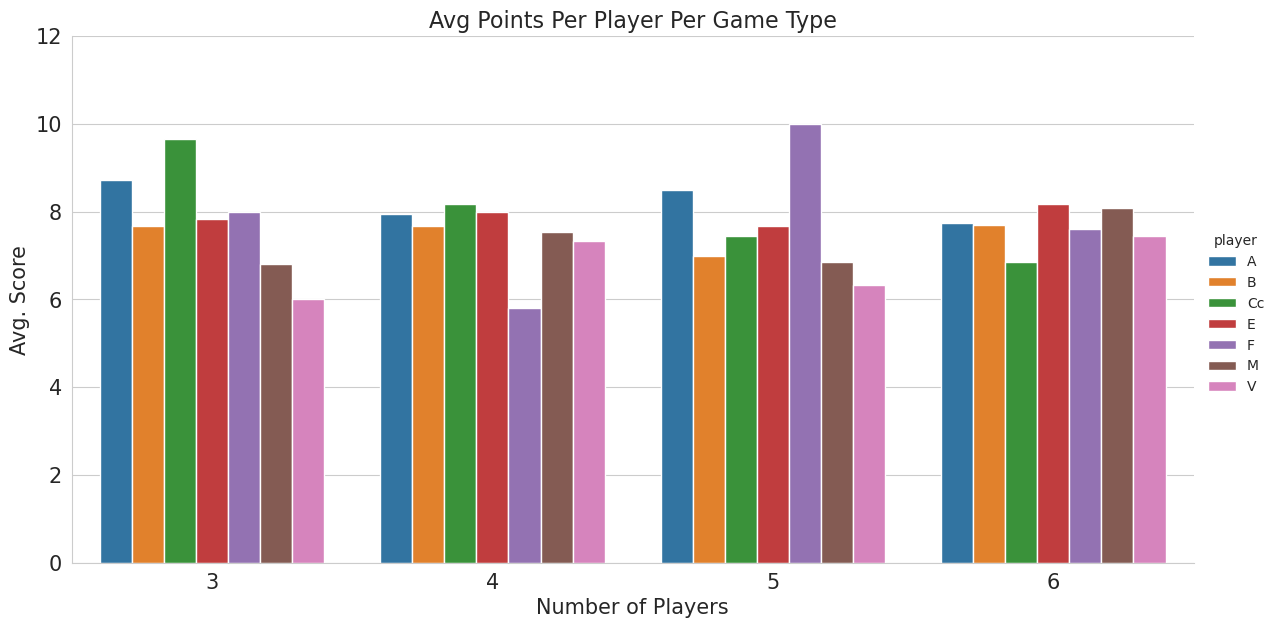

In [21]:
temp = copy.deepcopy(scores)
temp["num_of_players"] = temp.groupby("game_id")["rank"].transform('max')
temp = temp.groupby(["player", "num_of_players"], as_index=False).agg({'score': 'mean'})
rankings = scores.groupby('player').count().drop(['score'], axis=1)
# drop players with 5 games or less
temp = temp.loc[temp["player"].isin(rankings[rankings['result'] >= 5].index)]
temp["num_of_players"] = temp["num_of_players"].astype('int')
temp = temp[["player", "score", "num_of_players"]].drop_duplicates()
plt.figure(figsize=(20,12))
b = sns.catplot(data=temp, x="num_of_players", y="score", hue="player", kind="bar", height=6, aspect=2)
b.set_xlabels("Number of Players", fontsize=15)
b.set_ylabels("Avg. Score", fontsize=15)
b.set_xticklabels(fontsize=15)
b.set_yticklabels(fontsize=15)
ax = plt.gca()
ax.set_title("Avg Points Per Player Per Game Type", fontsize=16)
sns.set_style('whitegrid')


### Boxplot for Avg. Points per # of Players

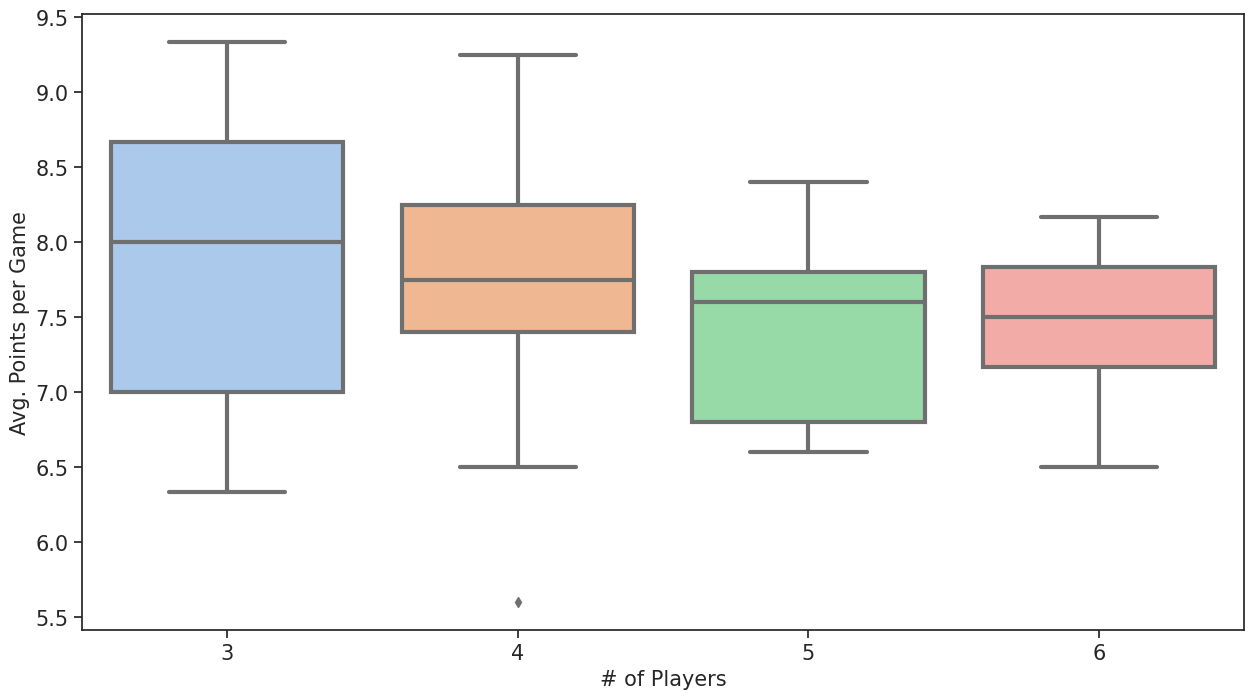

In [22]:
temp = copy.deepcopy(scores)
temp["avg_game_points"] = temp.groupby(["game_id"], as_index=False)["score"].transform('mean')
temp["num_of_players"] = raw_scores.groupby("game_id")["rank"].transform('max')
temp["num_of_players"] = temp["num_of_players"].astype('int')
temp = temp[["game_id", "avg_game_points", "num_of_players"]].drop_duplicates()
plt.figure(figsize=(15,8))

sns.set_theme(style="ticks", palette="pastel")
g = sns.boxplot(x=temp['num_of_players'],  y=temp["avg_game_points"], data=temp, linewidth=3)
g.set_yticklabels(g.get_yticks().astype("float").round(2), size = 15)
g.set_xlabel("# of Players", fontsize = 15)
g.set_ylabel("Avg. Points per Game", fontsize = 15)
g.tick_params(labelsize=15)

(0.0, 80.0)

<Figure size 1500x800 with 0 Axes>

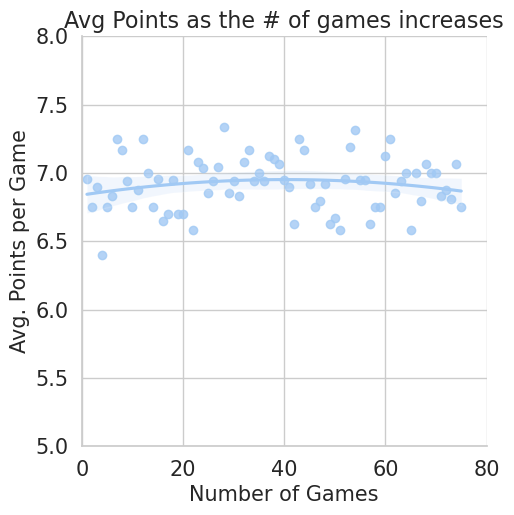

In [23]:
plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
ax = sns.lmplot(x="game_id", y="avg_game_points", data=temp, order=2)
ax.set(ylim=(0, 11))
ax.set_xlabels("Number of Games", fontsize = 15)
ax.set_ylabels("Avg. Points per Game", fontsize = 15)
ax.set_xticklabels(fontsize=15)
ax.set_yticklabels(fontsize=15)
ax = plt.gca()
ax.set_title("Avg Points as the # of games increases", fontsize=16)
ax.set_xlim(0,)




### Conditional Probability of winning a game given that $expression$

In [24]:
scores["max_rank"] = raw_scores.groupby("game_id")["rank"].transform('max')
scores["min_rank"] = raw_scores.groupby("game_id")["rank"].transform('min')
scores["is_last_player"] = np.where(scores["max_rank"] == scores["rank"], 1, 0)
scores["is_first_player"] = np.where(scores["min_rank"] == scores["rank"], 1, 0)
scores["winner"] = np.where(scores["result"] == "W", 1, 0)
scores['count'] = 1

In [25]:
def calculate_cond_prob(df: pd.DataFrame,
                       win_col: str,
                       value_col: list,
                       conditional_col: list):
    
    temp = pd.pivot_table(
        df, 
        values=value_col, 
        index=win_col, 
        columns=conditional_col, 
        aggfunc=np.size, 
        fill_value=0
    )
    PB = sum(temp.iloc[:,1])/sum(sum(temp.values))
    PANB = temp.iloc[1,1]/sum(sum(temp.values))

    print(f"Probability of winning the game, given that the {conditional_col[0]} is True {round(100*PANB/PB, 2)}% out of {sum(sum(temp.values))} samples.")

Ex:
- P(A) is the probability of a player wins. 
- P(B) is the probability of being last player.
- P(A|B) is the probability of winning the game, given that the player's turn is the last

P(A|B) = P(A ∩ B) / P(B)


In [26]:
calculate_cond_prob(df=scores,
                    win_col=["winner"],
                    value_col="count",
                   conditional_col=["is_last_player"])

calculate_cond_prob(df=scores,
                    win_col=["winner"],
                    value_col="count",
                   conditional_col=["is_first_player"])

calculate_cond_prob(df=scores,
                    win_col=["winner"],
                    value_col="count",
                   conditional_col=["builds_city_first"])

calculate_cond_prob(df=scores,
                    win_col=["winner"],
                    value_col="count",
                   conditional_col=["builds_settlement_first"])

calculate_cond_prob(df=scores,
                    win_col=["winner"],
                    value_col="count",
                   conditional_col=["buy_dev_card_first"])

calculate_cond_prob(df=scores,
                    win_col=["winner"],
                    value_col="count",
                   conditional_col=["longest_road"])

calculate_cond_prob(df=scores,
                    win_col=["winner"],
                    value_col="count",
                   conditional_col=["largest_army"])

Probability of winning the game, given that the is_last_player is True 20.51% out of 322 samples.
Probability of winning the game, given that the is_first_player is True 21.33% out of 322 samples.
Probability of winning the game, given that the builds_city_first is True 36.0% out of 322 samples.
Probability of winning the game, given that the builds_settlement_first is True 30.38% out of 322 samples.
Probability of winning the game, given that the buy_dev_card_first is True 36.36% out of 322 samples.
Probability of winning the game, given that the longest_road is True 46.03% out of 280 samples.
Probability of winning the game, given that the largest_army is True 53.49% out of 280 samples.


## Total Win Count per player per game type

<Figure size 2000x1000 with 0 Axes>

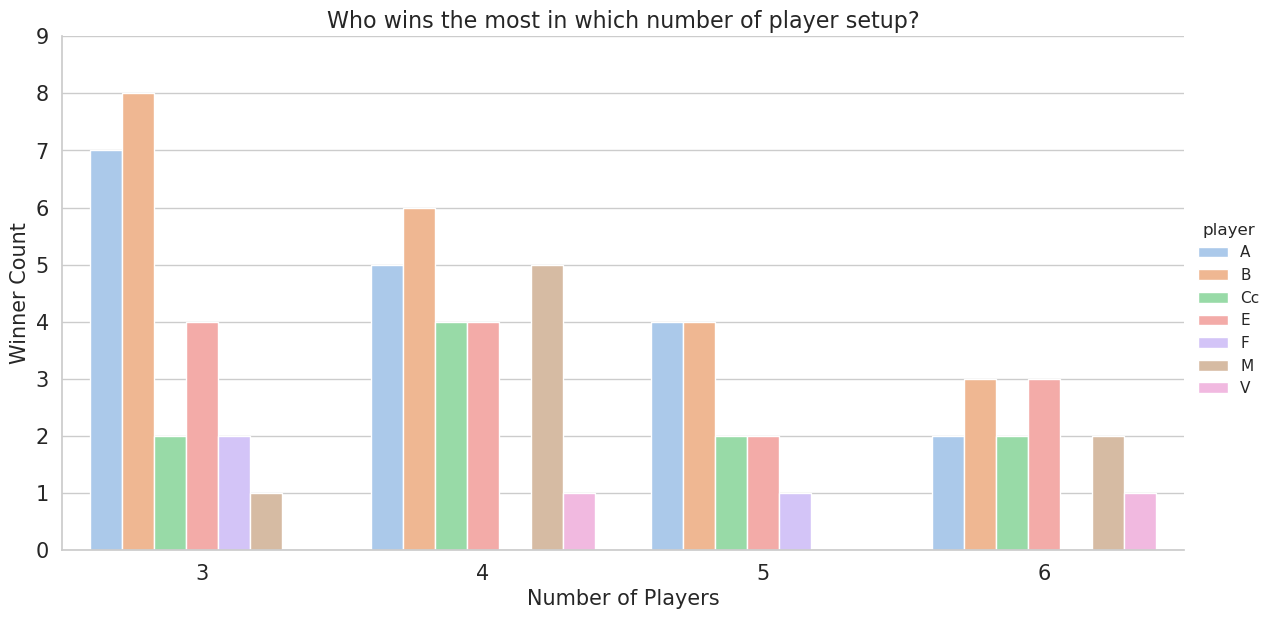

In [27]:
temp = copy.deepcopy(scores)
temp["num_of_players"] = temp.groupby("game_id")["rank"].transform('max')
temp = temp.groupby(["player", "num_of_players"], as_index=False).agg({'winner': 'sum'})
rankings = scores.groupby('player').count().drop(['score'], axis=1)
# drop players with 5 games or less
temp = temp.loc[temp["player"].isin(rankings[rankings['result'] >= 5].index)]
temp["num_of_players"] = temp["num_of_players"].astype('int')
temp = temp[["player", "winner", "num_of_players"]].drop_duplicates()
plt.figure(figsize=(20,10))
b = sns.catplot(data=temp, x="num_of_players", y="winner", hue="player", kind="bar", height=6, aspect=2)
b.set_xlabels("Number of Players", fontsize=15)
b.set_ylabels("Winner Count", fontsize=15)
b.set_xticklabels(fontsize=15)
b.set_yticklabels(fontsize=15)
ax = plt.gca()
ax.set_title("Who wins the most in which number of player setup?", fontsize=16)
sns.set_style('whitegrid')

In [28]:
temp = copy.deepcopy(scores)
temp["num_of_players"] = temp.groupby("game_id")["rank"].transform('max')
temp

,game_id,rank,date,player,winner,score,builds_city_first,builds_settlement_first,buy_dev_card_first,longest_road,largest_army,result,max_rank,min_rank,is_last_player,is_first_player,count,num_of_players
0,1.0,1.0,2022-02-22,B,0,7.0,0.0,0.0,1.0,NaN,NaN,L,4.0,1.0,0,1,1,4.0
1,1.0,2.0,2022-02-22,A,1,10.0,1.0,0.0,0.0,NaN,NaN,W,4.0,1.0,0,0,1,4.0
2,1.0,4.0,2022-02-22,V,0,8.0,0.0,1.0,0.0,NaN,NaN,L,4.0,1.0,1,0,1,4.0
3,1.0,3.0,2022-02-22,M,0,7.0,0.0,0.0,0.0,NaN,NaN,L,4.0,1.0,0,0,1,4.0
4,2.0,2.0,2022-03-06,A,0,5.0,0.0,1.0,0.0,NaN,NaN,L,3.0,1.0,0,0,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,3.0,4.0,2022-03-08,F,0,6.0,0.0,1.0,1.0,NaN,NaN,L,4.0,1.0,1,0,1,4.0
14,4.0,4.0,2022-03-09,F,0,4.0,0.0,0.0,0.0,NaN,NaN,L,4.0,1.0,1,0,1,4.0
88,24.0,2.0,2022-04-01,F,0,8.0,0.0,1.0,0.0,0.0,0.0,L,6.0,1.0,0,0,1,6.0
255,62.0,3.0,2022-11-30,B,0,8.0,1.0,0.0,1.0,0.0,0.0,L,4.0,1.0,0,0,1,4.0


### Win/Loss Streaks
Graph the win/loss streaks for each player

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
scores = scores.sort_values("date")
scores.loc[scores['result'] == "W", "wins"] = 1
scores.loc[scores['result'] == "L", "losses"] = -1

In [31]:
def plot_win_lose_streaks(player):
    fig, ax = plt.subplots(figsize=(10,1))
    # add a horizontal line at y=0
    plt.axhline(y=0, color='black', linewidth=3)
    
    # separate wins, draws and losses for so we can show them in different colors
    scores[scores['player']==player]['wins'].plot.bar(ax=ax, color='green', width=1)
    scores[scores['player']==player]['losses'].plot.bar(ax=ax, color='red', width=1)
    
    plt.title(player, loc='left')

    ax.tick_params(bottom=False, labelbottom=False)
    plt.gca().invert_xaxis()

    plt.show()

In [32]:
players = scores.drop_duplicates('player')['player']
def wins_in_every_x_game(player, df):
    data = df[(df['player']==player)]
    data.fillna({"wins": 0}, inplace=True)
    data["game_id"] = data["count"].cumsum()
    data["previous_status"] = data["wins"].shift(1)
    data["previous_game"] = data["game_id"].shift(1)
    data.loc[data["previous_status"] == 1, "last_win_game"] = data.loc[data["previous_status"] == 1, "previous_game"]
    data.loc[(data["game_id"] == data.game_id.max()) & (data["wins"] == 1), "last_win_game"] = data.game_id.max()
    data = data.loc[~data["last_win_game"].isnull()]
    data["previous_last_win_game"] = data["last_win_game"].shift(1)
    data["diff"] = data["last_win_game"] - data["previous_last_win_game"]
    data.fillna({"diff": data.last_win_game}, inplace=True)
    data["game_id"] = data["count"].cumsum()
    return data[["game_id", "player", "diff"]]
winning = pd.DataFrame()
for player in players:
    data = wins_in_every_x_game(player, df=scores)
    winning = pd.concat([winning, data], axis=0)
    mean_ = round(np.mean(data["diff"]),2)
    print(f"{player} Wins in Every {mean_ if mean_ > 0 else 0} game")
winning = winning.reset_index(drop=True)
winning["rolling_mean"] = winning.groupby("player")["diff"].apply(lambda x: x.rolling(2).mean())

B Wins in Every 3.19 game
E Wins in Every 4.23 game
M Wins in Every 5.12 game
Cc Wins in Every 4.2 game
V Wins in Every 5.5 game
A Wins in Every 3.11 game
F Wins in Every 3.67 game
Ck Wins in Every 0 game
Ak Wins in Every 0 game
I Wins in Every 0 game
Ap Wins in Every 0 game


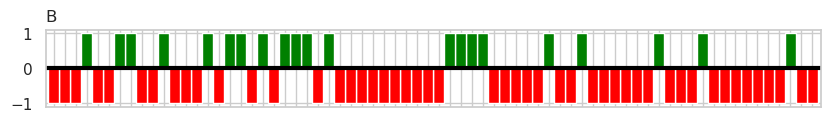

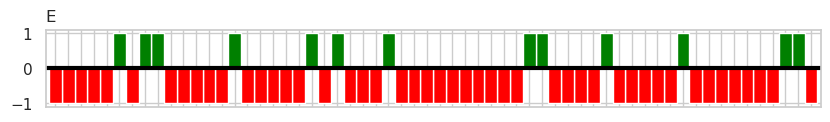

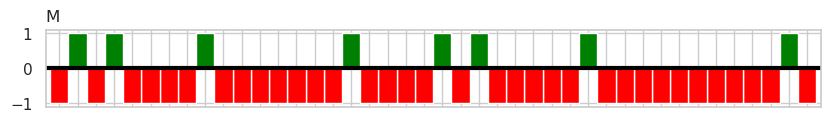

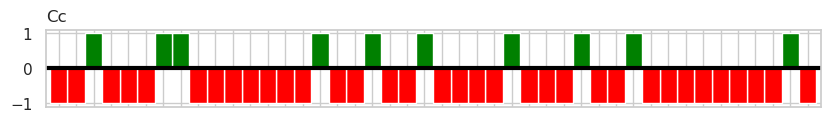

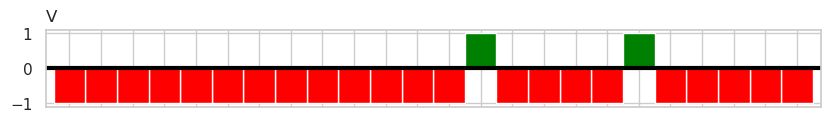

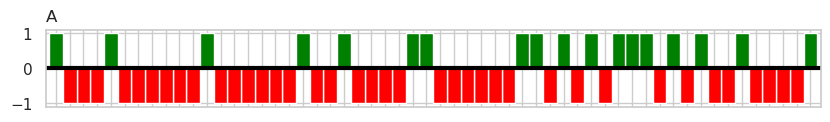

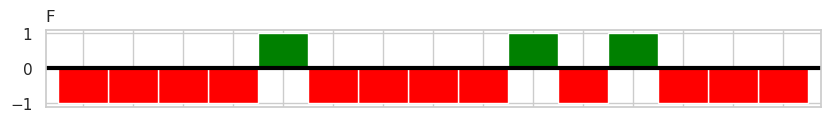

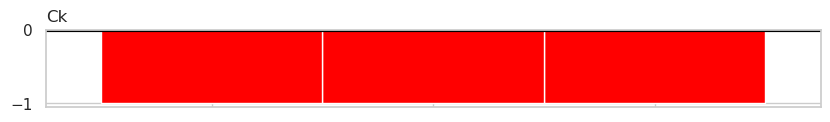

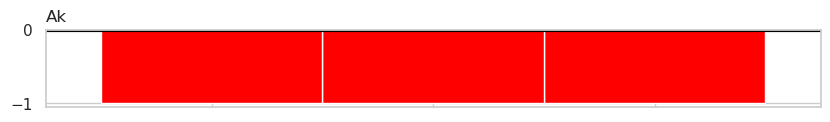

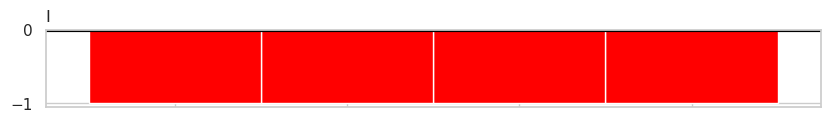

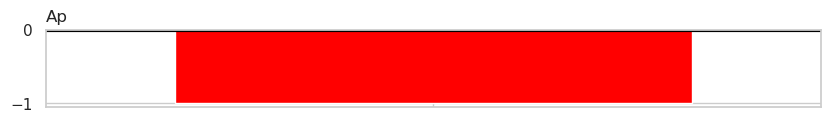

In [33]:
for player in players:
    plot_win_lose_streaks(player)

## Rankings

Show and rank via win percentage for each player. Alternatives would be
 - total number of wins
 - total IMPs scored
 
but go with win percentages for now

In [34]:
rankings = scores.groupby('player').count().drop(['score'], axis=1)
# drop players with 3 games or less
rankings = rankings[rankings['result'] >= 5]
rankings['pct'] = rankings['wins'] / rankings['result']
rankings = rankings.sort_values(by='pct', ascending=False)

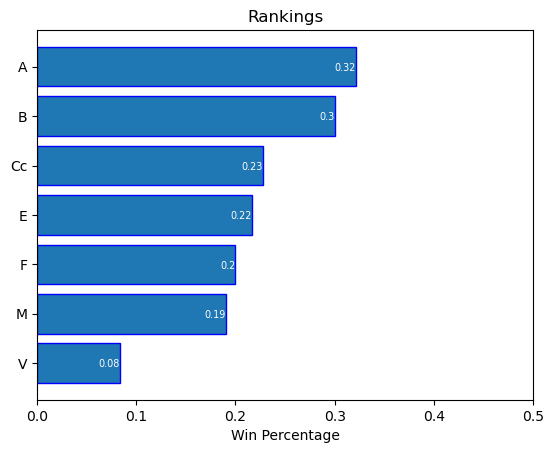

In [35]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(rankings))
ax.barh(y_pos, rankings['pct'], edgecolor='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(list(rankings.index))
ax.invert_yaxis()  # highest first
ax.set_xlabel('Win Percentage')
ax.set_title('Rankings')

for i in range(len(rankings.index)):
    plt.text(rankings['pct'][i], y_pos[i], round(rankings['pct'][i],2), 
             ha='right', va='center_baseline', fontsize='x-small', color='white')

ax.set_xlim((0, 0.5))
plt.show()

## Confidence Intervals

In probability theory and statistics, the binomial distribution with parameters n and p is the discrete probability distribution of the number of successes in a sequence of n independent experiments, each asking a yes–no question, and each with its own Boolean-valued outcome: success (with probability p) or failure (with probability q = 1 − p).

Calculate the confidence interval for the win percentages above, i.e. the *correct* win percentage for each player lies somewhere in the interval calculated with a high probability.

In [36]:
from scipy.stats import binomtest

In [37]:
intervals = {}
for i in range(len(rankings.index)):
    result = binomtest(int(rankings.iloc[i]['wins']), int(rankings.iloc[i]['result']), rankings.iloc[i]['pct'], alternative='two-sided')
    intervals[rankings.index[i]] = result.proportion_ci(confidence_level=0.95)

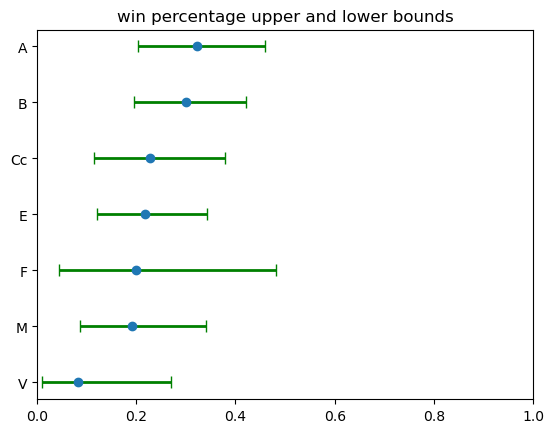

In [38]:
fig, ax = plt.subplots()
x = list()
y = list()
error_range = list()

# reverse for descending order
for i in range(len(intervals.keys())-1,-1, -1):
    # player, center, lower_limit, upper_limit
    lines = rankings.index[i], rankings['pct'][rankings.index[i]], intervals[rankings.index[i]][0], intervals[rankings.index[i]][1]
    x.append(lines[1])
    y.append(lines[0])
    error_range.append([lines[1]-lines[2], lines[3]-lines[1]])

ax.errorbar(x, y, xerr=np.array(error_range).T, fmt='o', ecolor='green', elinewidth=2, capsize=4)

# tidy up the figure
ax.set_xlim((0, 1))
ax.set_title('win percentage upper and lower bounds')
plt.show()

## Rankings - Cont

Another ranking method is to use points for each game: 1 points for a win, 0 points for a loss.

In [39]:
raw_scores["points"] = 0
raw_scores.loc[raw_scores["player"] == raw_scores["winner"], "points"] = 1
scores = copy.deepcopy(raw_scores)

In [40]:
league = pd.DataFrame()
league['win_count'] = scores.groupby(by="player")['points'].sum()
league['games_played'] = scores.groupby(by="player")['points'].count()
league['scores'] = scores.groupby(by="player")['score'].sum()
league['points_per_game'] = league['scores'] / league['games_played']
league['win_perc'] = league['win_count'] / league['games_played']
league.sort_values(by=['win_perc'], ascending=False, inplace=True)

league

,win_count,games_played,scores,points_per_game,win_perc
player,,,,,
A,18,56,460.0,8.214286,0.321429
B,21,70,529.0,7.557143,0.300000
Cc,10,44,339.0,7.704545,0.227273
E,13,60,475.0,7.916667,0.216667
F,3,15,109.0,7.266667,0.200000
M,8,42,310.0,7.380952,0.190476
V,2,24,170.0,7.083333,0.083333
Ak,0,3,19.0,6.333333,0.000000
Ap,0,1,6.0,6.000000,0.000000


In [41]:
def find_ranks_in_game(data: pd.DataFrame, score_col: str) -> pd.DataFrame:
    data["rank_in_game"] = data.groupby("game_id")[score_col].rank("dense", ascending=False)
    return data

In [42]:
scores = find_ranks_in_game(data=scores, score_col="score") 

### Most occurence by rank in game

In [43]:
# When we eliminate the player with the most win count, what is the win count order?
data = scores[["player", "rank_in_game"]]
temp_ = {}
delete_users = ["A"]
for rank_ in data.sort_values("rank_in_game").rank_in_game.unique():
    temp = data.loc[(data["rank_in_game"] == rank_) & (~data["player"].isin(delete_users))]
    temp["count"] = 1
    temp = temp.groupby(["player", "rank_in_game"])["count"].sum().reset_index()
    if len(temp) > 0:
        delete_user = list(temp.iloc[temp.groupby("rank_in_game")["count"].idxmax().values].player)[0]
        delete_users.append(delete_user)
        temp_[delete_user] = rank_
print(temp_)

{'B': 1.0, 'E': 2.0, 'M': 3.0, 'V': 4.0, 'Cc': 5.0, 'Ak': 6.0}


### Pairwise Win Comparison

In [44]:
from itertools import permutations 
pairs = {}
winner = {}
for game_id in scores.game_id.unique():
    temp = scores.loc[(scores["game_id"] == game_id)]
    
    winner_ = temp.winner.unique()
    comb = permutations(temp.player.unique(), 2)
    score_list = list(set(temp.score.unique()))
    score_list.sort()
    temp_max = score_list[-2]
    #temp = temp.loc[temp["player"] != temp["winner"]]
    # Print the obtained combinations
    for i in list(comb):
        if (temp.loc[(temp["player"] == i[0])].score.iloc[0] != temp.loc[(temp["player"] == i[1])].score.iloc[0]) and \
            (temp.loc[(temp["player"] == i[0])].score.iloc[0] > temp.loc[(temp["player"] == i[1])].score.iloc[0]):
            if i not in pairs:
                pairs[i] = 0
            pairs[i] += 1
        if (winner_ == i[0] or winner_ == i[1]) and (bool(len(temp.loc[(temp["winner"] == i[0])]))):
            if i not in winner:
                winner[i] = 0
            winner[i] += 1

In [45]:
pairwise = pd.DataFrame(pairs.values(), index=pairs.keys(), columns=["win_count"]).reset_index()
pairwise["pair"] = pairwise["level_0"] + " - " + pairwise["level_1"]
pairwise = pairwise.drop(["level_0", "level_1"], axis=1)
pairwise = pairwise.sort_values(["win_count"], ascending=False)

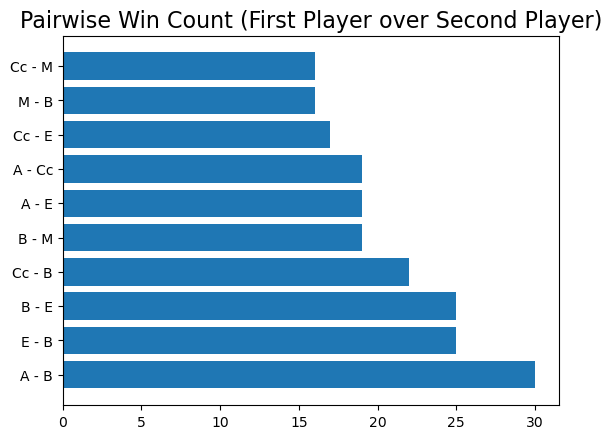

In [46]:
plt.barh(pairwise.head(10).pair, pairwise.head(10).win_count)
ax = plt.gca()
ax.set_title("Pairwise Win Count (First Player over Second Player)", fontsize=16)
sns.set_style('whitegrid')

In [47]:
pairwise_winner = pd.DataFrame(winner.values(), index=winner.keys(), columns=["win_count"]).reset_index()
pairwise_winner["pair"] = pairwise_winner["level_0"] + " - " + pairwise_winner["level_1"]
pairwise_winner = pairwise_winner.drop(["level_0", "level_1"], axis=1)
pairwise_winner = pairwise_winner.sort_values(["win_count"], ascending=False)

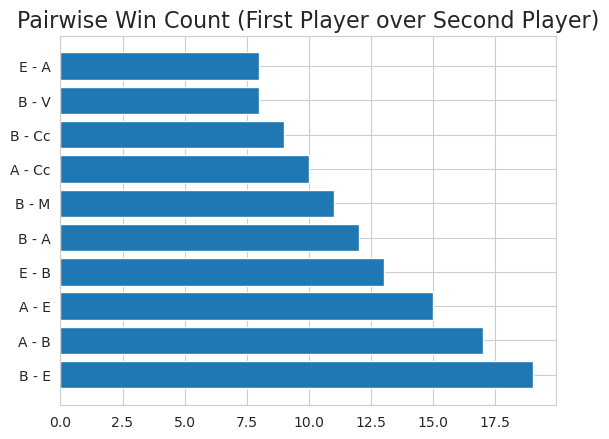

In [48]:
plt.barh(pairwise_winner.head(10).pair, pairwise_winner.head(10).win_count)
ax = plt.gca()
ax.set_title("Pairwise Win Count (First Player over Second Player)", fontsize=16)
sns.set_style('whitegrid')

# ideas

- detailed pairwise comparison
- fastest winner
- win percent based on game type (extension or not)
- is longest road safe?
- is first of sth good?
- 3-4-5-6 players, does being the last person disadvantage?
- winner by place
- longest streak?